In [2752]:
import numpy as np
import math

In [2753]:
def f(x):
    return 3*x**2 - 4*x + 5

x = np.arange(-5,5,0.25)

y = f(x)
y

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

In [2754]:
import matplotlib.pyplot as plt

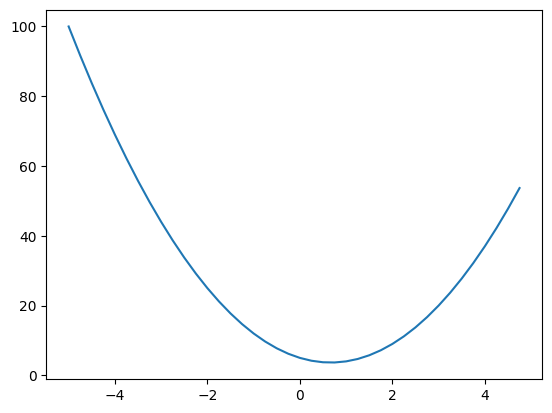

In [2755]:
# 展示一维函数的x轴的变化导致y轴的变化
plt.plot(x,y)

In [2756]:
f(5.0)

60.0

In [2757]:
# derivative means senstive of function in that point, bigger positive means slope x a little distance makes fucntion become bigger
# 导数的定义是什么
# 从数学公式上来说，在x某一点的导数等于如下dx的公式，h取极限0
# 定义上x在某一点的导数为：x向正方向增大极微小的数值时，对应结果y值的变化程度，直观上理解为函数的敏感度，英文（from video karpathy）：sensitive
# 可以由此想象，当某点的x增加了极微小的h时，对应的y值变化的非常大，那么可以确定的是，在该点函数是极其敏感的，对应可以说x在该点的变化将会引发函数结果y值的大幅波动
# 那么在数学上就是该点x的导数的绝对值一定具有比较大的值
# 如果在该点上x向正方向增加极微小h值导致函数结果y值增加，那么该点的导数就会相应的是正值，在二维图像上看该点的函数曲线是上升状态
# 如果在该点上x向正方向增加极微小h值导致函数结果y值减小，那么该点的导数就会相应的是负值，在二维图像上看该点的函数曲线是下降状态
# 如果在某一点x的导数为0，意味着函数在该点x的正方向增加极小标量的h将不会影响函数的结果y值，从直觉来说即函数在该点没有敏感度，不会变化，在图像上看该点必定是函数的极值点
# 导数为0意味着极大值或者极小值

# 应用公式求a在3.0点时的导数近似值
h = 0.01
a=3.0
def dx(a):
    return (f(a+h)-f(a))/h
dx(a)

14.029999999999632

In [2758]:
a=-2.0
print(f"dx(a)={dx(a)}")
print(f"f(a)={f(a)}")
print(f"f(a={a})={f(-a)}")
f(a)+0.01*dx(a)

dx(a)=-15.970000000000084
f(a)=25.0
f(a=-2.0)=9.0


24.8403

In [2759]:
# 导数极值点
dx(2/3)

0.02999999999997449

In [2760]:
h = 0.001

#inputs
a=2.0
b=-3.0
c=10.0

d1 = a*b+c
a+=h
d2 = a*b+c
print("d1:",d1)
print("d2:",d2)
print("slop:",(d2-d1)/h)

d1: 4.0
d2: 3.997
slop: -3.0000000000001137


In [2761]:
class Value_with_no_accumulate_grad:
    def __init__(self,data,_children=(),_op="",label=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad=0
        self._backward = lambda: None
    # help print something better
    def __repr__(self):
        return f"Value(data={self.data})"
    # override operation + ,it will use a.__add__(b)
    def __add__(self,other):
        out = Value(self.data+other.data,(self,other),"+")
        def backward():
            self.grad = 1.0*out.grad
            other.grad = 1.0*out.grad
        self._backward = backward
        if(isinstance(other,float)):
            return Value(self.data+other,(self,other),"+")
        return out
    def __mul__(self,other):
        out = Value(self.data*other.data,(self,other),"*")
        def backward():
            self.grad = out.grad * other.data
            other.grad = out.grad * self.data
        self._backward = backward
        return out
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        def backward():
            self.grad = 1-t**2
        self._backward = backward
        return Value(t,(self,),'tanh')
    def backward(self):
        topo = []
        visited = set()
        def build_topo(node):
            if node not in visited:
                topo.append(node)
                visited.add(node)
                for child in node._prev:
                    build_topo(child)
        self.grad = 1
        build_topo(self)
        for node in topo:
            node._backward()
        

In [2762]:
# 构造 Value 数据类型用来存储数据的变化跟踪
class Value:
    def __init__(self,data,_children=(),_op="",label=""):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad=0
        self._backward = lambda: None
    # help print something better
    def __repr__(self):
        if(self.label):
            return f"Value(label={self.label}  data={self.data})"
        else:
            return f"Value(data={self.data})"
    # override operation + ,it will use a.__add__(b)
    def __add__(self,other):
        if(not isinstance(other,Value)):
            other = Value(other)
        out = Value(self.data+other.data,(self,other),"+")
        def _backward():
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad
        out._backward = _backward
        return out
    def __radd__(self,other):
        return self+other
    def __mul__(self,other):
        if(not isinstance(other,Value)):
             other = Value(other)
        out = Value(self.data*other.data,(self,other),"*")
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        return out
    def __rmul__(self, other):
        return self-other
        
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t,(self,),'tanh')
        def _backward():
            # 忘记grad会导致第一次计算正确但是backward出错
            self.grad += (1-t**2)*out.grad
        out._backward = _backward
        return out

    def exp(self):
        out = Value(math.exp(self.data),(self,),'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
        
    def __sub__(self,other):
        if(not isinstance(other,Value)):
            other = Value(other)
        out = Value(self.data-other.data,(self,other),'-')
        def _backward():
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad
        out._backward = _backward
        return out

    def __rsub__(self,other):
        return self.__sub__(other)
        
    def __pow__(self,other):
        out = Value(self.data**other,(self,),'pow')
        def _backward():
            self.grad += other*self.data**(other-1)*out.grad
        out._backward = _backward
        return out
        
    def __truediv__(self,other): 
        return self * other ** -1
        
    def backward(self):
        topo = []
        visited = set()
        def build_topo(node):
            if node not in visited:
                visited.add(node)             
                for child in node._prev:
                    build_topo(child)    
                # 必须等到所有属于该node的子节点递归遍历完成之后才能在topo中存储该节点，如果提前存储了该node可能会导致某一条遍历线深度超过该节点的位置
                # 从而在顺序上先存储了深度更深的节点，会造成该节点的非全部下属节点遍历完成就继续向后遍历
                # 由于反向传播算法在计算该节点的梯度grad时，需要依赖该节点全部子节点的梯度，所以可能会出现计算错误
                topo.append(node)
        self.grad = 1
        build_topo(self)
        for node in reversed(topo):
            node._backward()

    def backward_error(self):
        topo = []
        visited = set()
        def build_topo(node):
            if node not in visited:
                visited.add(node)   
                topo.append(node)
                for child in node._prev:
                    build_topo(child)             
                    
        build_topo(self)
        self.grad = 1.0
        for node in topo:
            node._backward()
        



In [2763]:
class Value_from_karpathy:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self): 
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


In [2764]:
a = Value(2.0,label='a')
b = Value(-3.0,label='b')
print(f"a+b = {a+b}")
print(f"a*b = {a*b}")
c = Value(10,label="c")
e = a*b
e.label = "e"
d = e+c
d.label = 'd'
f = Value(-2.0,label="f")
L = f*d
L.label = "L"
print(f"a*b+c = d={d}")
z = Value(a)+Value(b)
print(f"{z._prev}")
print(f"{z._op}")

a+b = Value(data=-1.0)
a*b = Value(data=-6.0)
a*b+c = d=Value(label=d  data=4.0)
{Value(data=Value(label=a  data=2.0)), Value(data=Value(label=b  data=-3.0))}
+


In [2765]:
# jupyter的继承环境变量有可能未完整继承系统变量，所以手动将绘图Graphviz执行路径的环境变量引入
import os
# print(os.environ)
# 手动增加环境变量
os.environ["PATH"] += os.pathsep + 'C:\\Program Files\\Graphviz\\bin'

In [2766]:
# pip install graphviz
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label,n.data,n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

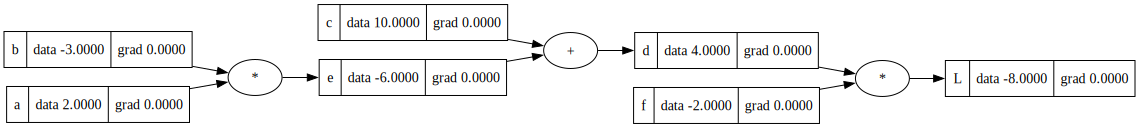

In [2767]:
# 图示跟踪结果
draw_dot(L)

In [2768]:
# 手动计算各值的梯度
h = 0.001
derivative_f = ((f.data+h)*d.data - f.data*d.data)/h
print(f"derivate dL/df = {derivative_f}")
#计算自己对自己的梯度为1
L.grad = 1
f.grad = 4
d.grad = -2
# dL/dd = -2
# dd/dc = 1 dd/de = 1
# dL/dc = (dL/dd) * (dd/dc) = -2 dL/de = (dL/dd) * (dd/de)
# why derivate chain rule use multiply, like bicycle speed is twice than human, car speed is four times than bicycle, so car speed is eight times than human.
c.grad = -2
e.grad = -2
# dL/da = dL/de * de/da = -2*b = -2*-3
a.grad = e.grad * b.data
b.grad = e.grad * a.data

derivate dL/df = 3.9999999999995595


In [2769]:
# prove it
# 通过导数定义计算a点相对与L的导数
def lol():
    h = 0.001;
    
    a = Value(2.0,label='a')
   
    b = Value(-3.0,label='b')
    c = Value(10,label="c")
    e = a*b
    e.label = "e"
    d = e+c
    d.label = 'd'
    f = Value(-2.0,label="f")
    L1 = f*d
    L1.label = "L1"
    
    a = Value(2.0,label='a')
    a.data+=h;
    b = Value(-3.0,label='b')
    c = Value(10,label="c")
    e = a*b
    e.label = "e"
    d = e+c
    d.label = 'd'
    f = Value(-2.0,label="f")
    L2 = f*d
    L2.label = "L2"
    return (L2.data-L1.data)/h

# caculate dL/da
lol()

6.000000000000227

In [2770]:
# adjust data see how grad influence result
# 通过观测调整变量值在梯度方向进行移动时如何影响函数结果的
step = 0.01
# a.data+=step*a.grad
# b.data+=step*b.grad
c.data+=step*c.grad
# f.data+=step*f.grad

L3 = (a*b+c)*f
L3

Value(data=-7.960000000000001)

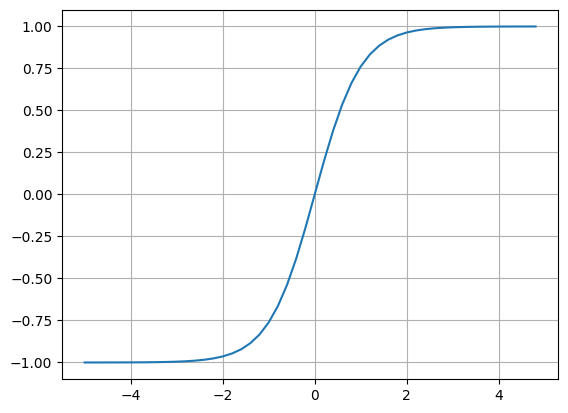

In [2771]:
# show the active function
plt.plot(np.arange(-5,5,0.2),np.tanh(np.arange(-5,5,0.2)));
plt.grid()

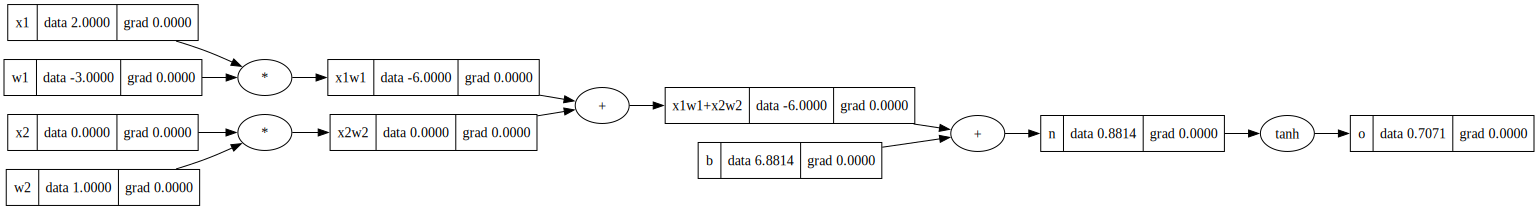

In [2772]:
# simulate neural network
# inputs x1,x2
# 模拟神经元，两个输入信号x1,x2，对应输入信号的权重w1,w2
# 使用tanh作为激活函数，将神经元的输出控制在[-1,1]的范围，防止输出数据范围过大，造成稀疏
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
# weights w1,w2
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
# bias of the neuron
# bias变量表示神经元本身的固有兴奋基础值，越高的基础值代表该神经元更容易被激活可以在接收到较小的刺激(输入数据)即输入更高的值
b = Value(6.88137,label='b')
x1w1 = x1*w1
x1w1.label = 'x1w1'
x2w2 = x2*w2
x2w2.label = 'x2w2'
x1w1x2w2 = x1w1+x2w2
x1w1x2w2.label = 'x1w1+x2w2'
n = x1w1x2w2+b
n.label = 'n'
o = n.tanh()
o.label = 'o'

draw_dot(o)

In [2773]:
# caculate the grad by manually, back propagation
# 手动计算各点的梯度
# o.grad = 1.0
# # according the caculus rules
# d_tanh = 1-o.data**2
# n.grad = d_tanh
# b.grad = 1*n.grad
# x1w1x2w2.grad = n.grad * 1
# x1w1.grad = x1w1x2w2.grad *1
# x2w2.grad = x1w1x2w2.grad *1
# x2.grad = x2w2.grad * w2.data
# w2.grad = x2w2.grad * x2.data
# x1.grad = x1w1.grad * w1.data
# w1.grad = x1w1.grad * x1.data

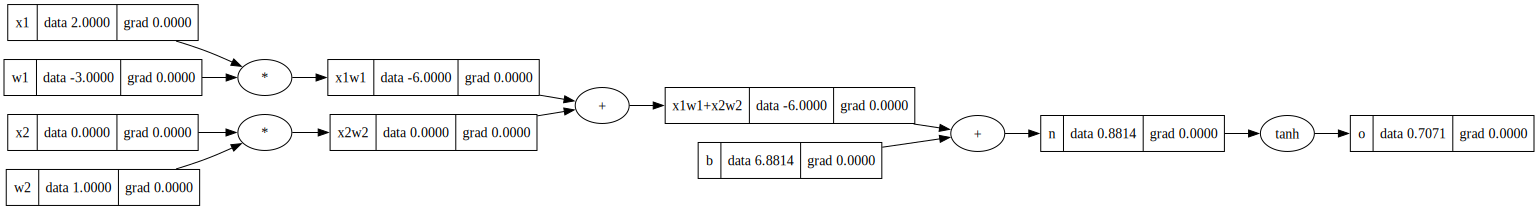

In [2774]:
draw_dot(o)

In [2775]:
# set the backward function to caculate the grad in Value class

In [2776]:
# initialize the root grad
# 反向计算首先要对结果梯度初始化，然后再往前计算其梯度
o.grad =1.0

In [2777]:
# o._backward()

In [2778]:
# n._backward()

In [2779]:
# x1w1x2w2._backward()

In [2780]:
# b._backward()

In [2781]:
# x1w1._backward()

In [2782]:
# x2w2._backward()

In [2783]:
# x1._backward();x2._backward()

In [2784]:
# w1._backward();w2._backward()

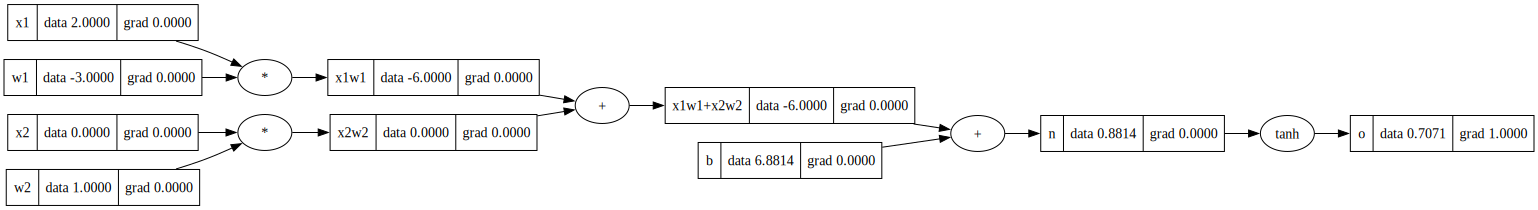

In [2785]:
draw_dot(o)

In [2786]:
# traverse all the node for caculate it's grad
# 通过递归按顺序遍历参与计算的全部节点
topo = []
visited = set()
def build_topo(node):
    if node not in visited:   
        visited.add(node)
        for child in node._prev:
            build_topo(child)
        topo.append(node)
build_topo(o)
topo

[Value(label=x2  data=0.0),
 Value(label=w2  data=1.0),
 Value(label=x2w2  data=0.0),
 Value(label=x1  data=2.0),
 Value(label=w1  data=-3.0),
 Value(label=x1w1  data=-6.0),
 Value(label=x1w1+x2w2  data=-6.0),
 Value(label=b  data=6.88137),
 Value(label=n  data=0.8813700000000004),
 Value(label=o  data=0.7071049876722272)]

In [2787]:
# traverse all the node for caculate it's grad
# 遍历的错误示范，提前存储了节点导致节点的存储顺序错误
topo_error = []
visited_error = set()
def build_topo_error(node):
    if node not in visited_error:   
        visited_error.add(node)
        topo_error.append(node)
        for child in node._prev:
            build_topo_error(child)
        
build_topo_error(o)
topo_error

[Value(label=o  data=0.7071049876722272),
 Value(label=n  data=0.8813700000000004),
 Value(label=x1w1+x2w2  data=-6.0),
 Value(label=x2w2  data=0.0),
 Value(label=x2  data=0.0),
 Value(label=w2  data=1.0),
 Value(label=x1w1  data=-6.0),
 Value(label=x1  data=2.0),
 Value(label=w1  data=-3.0),
 Value(label=b  data=6.88137)]

In [2788]:
# o.grad = 1.0
# for node in topo:
#     node._backward()

In [2789]:
# build own backward
# 将上述遍历算法存入对象中实现从结果的反向传播计算
o.backward()

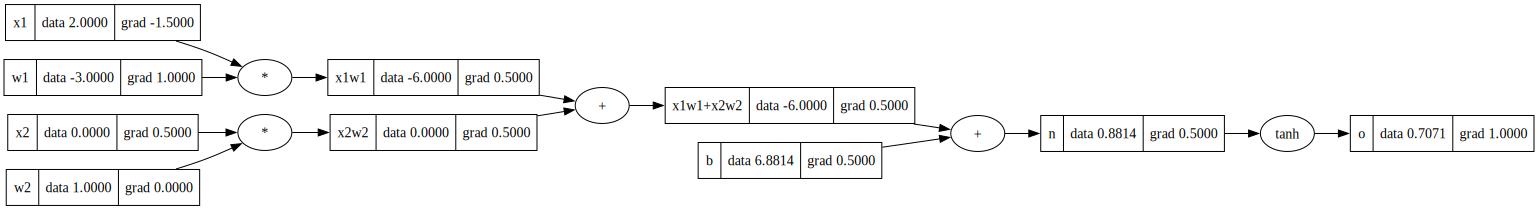

In [2790]:
draw_dot(o)

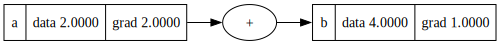

In [2791]:
# fix a bug about use same variable multiple
# to solve this problem, just refrence the mutiple variables in caculus, accumalate it's grad
# 解决当同一个变量参与了多次计算的问题，需要修改Value类中操作符中反向传播计算梯度时使用累加来解决bug
a= Value(2.0,label='a')
b = a+a
b.label = 'b'
b.backward()
draw_dot(b)

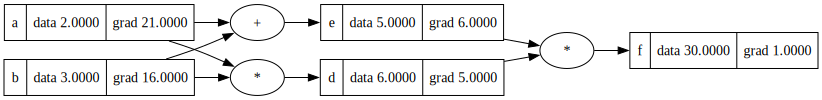

In [2792]:
# this is another example
# 这是另一个关于为什么要进行梯度累加的例子
a = Value(2,label='a')
b = Value(3,label='b')
d = a*b;d.label = 'd'
e = a+b;e.label = 'e'
f = d*e;f.label = 'f'
f.backward()
draw_dot(f)

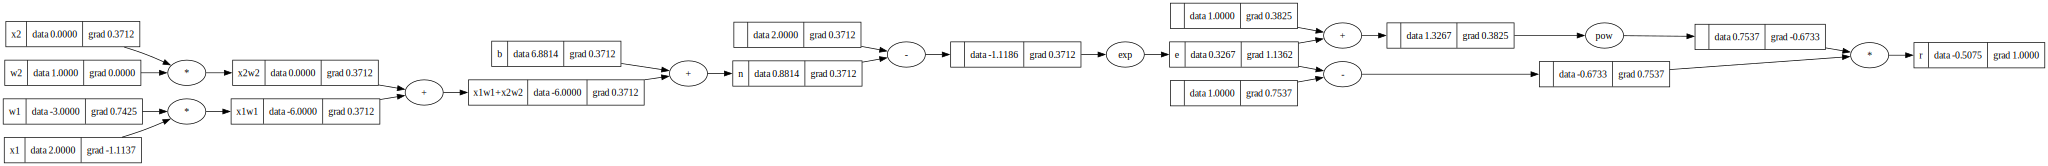

In [2793]:
# simulate neural network, make tanh function explict atom
# 因为tanh可以被分解为更基础的数学计算公式因此将其进行分解
# inputs x1,x2
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
# weights w1,w2
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
# bias of the neuron
b = Value(6.88137,label='b')
x1w1 = x1*w1
x1w1.label = 'x1w1'
x2w2 = x2*w2
x2w2.label = 'x2w2'
x1w1x2w2 = x1w1+x2w2
x1w1x2w2.label = 'x1w1+x2w2'
n = x1w1x2w2+b
n.label = 'n'
# r = n.tanh()
# r.label='r'
#--------
e = (2.0*n).exp()
e.label = 'e'
w = Value(1,label='w')
v = Value(-1,label='v')
r = (e-1)/(e+1)
#--------
r.label='r'

r.backward()

draw_dot(r)

In [2794]:
# 正确遍历函数
topo = []
visited = set()
build_topo(r)
topo

[Value(label=b  data=6.88137),
 Value(label=x1  data=2.0),
 Value(label=w1  data=-3.0),
 Value(label=x1w1  data=-6.0),
 Value(label=x2  data=0.0),
 Value(label=w2  data=1.0),
 Value(label=x2w2  data=0.0),
 Value(label=x1w1+x2w2  data=-6.0),
 Value(label=n  data=0.8813700000000004),
 Value(data=2.0),
 Value(data=-1.1186299999999996),
 Value(label=e  data=0.32672710427882445),
 Value(data=1),
 Value(data=-0.6732728957211755),
 Value(data=1),
 Value(data=1.3267271042788245),
 Value(data=0.7537345071001432),
 Value(label=r  data=-0.5074690142002863)]

In [2795]:
# 错误的遍历函数
topo_error = []
visited_error = set()
build_topo_error(r)
topo_error

[Value(label=r  data=-0.5074690142002863),
 Value(data=-0.6732728957211755),
 Value(label=e  data=0.32672710427882445),
 Value(data=-1.1186299999999996),
 Value(label=n  data=0.8813700000000004),
 Value(label=b  data=6.88137),
 Value(label=x1w1+x2w2  data=-6.0),
 Value(label=x1w1  data=-6.0),
 Value(label=x1  data=2.0),
 Value(label=w1  data=-3.0),
 Value(label=x2w2  data=0.0),
 Value(label=x2  data=0.0),
 Value(label=w2  data=1.0),
 Value(data=2.0),
 Value(data=1),
 Value(data=0.7537345071001432),
 Value(data=1.3267271042788245),
 Value(data=1)]

In [2796]:
import torch

In [2797]:
x = torch.Tensor([2.0]).double()
x.item()

2.0

In [2798]:
x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.88137]).double()
n = x1*w1+x2*w2 + b
o = torch.tanh(n)
print(f'the result of o is {o.data.item()}')
o.backward()
print(f'the grad of x1 is {x1.grad.item()}')
print(f'the grad of w1 is {w1.grad.item()}')
print(f'the grad of x2 is {x2.grad.item()}')
print(f'the grad of w2 is {w2.grad.item()}')

the result of o is 0.7071050214706146
the grad of x1 is -1.500007465833125
the grad of w1 is 1.0000049772220834
the grad of x2 is 0.5000024886110417
the grad of w2 is 0.0


In [2799]:
import random

In [2800]:
class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self,x):
        # print(list(zip(self.w,x)))
        active = sum(wi*xi for wi,xi in zip(self.w,x))+self.b
        out = active.tanh()
        return out
    def parameters(self):
        return [self.b]+self.w

class Layer:
    # nin 表示层内的每个神经元接受多少个输入,nout表示该层有多少个输出结果即有多少个神经元
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        # 如果最后一层只有一个神经元即数组中只有一个输入元素，那么输出该值(for:输出可视化)
        return outs[0] if len(outs)==1 else outs
    def parameters(self):
        ps = []
        for neuron in self.neurons:
            ps.extend(neuron.parameters())
        return ps

class MLP:
    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(sz)-1)]
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        ps = []
        for layer in self.layers:
            ps.extend(layer.parameters())
        return ps

In [2801]:
n = Neuron(3)
o = n([10,20,30])

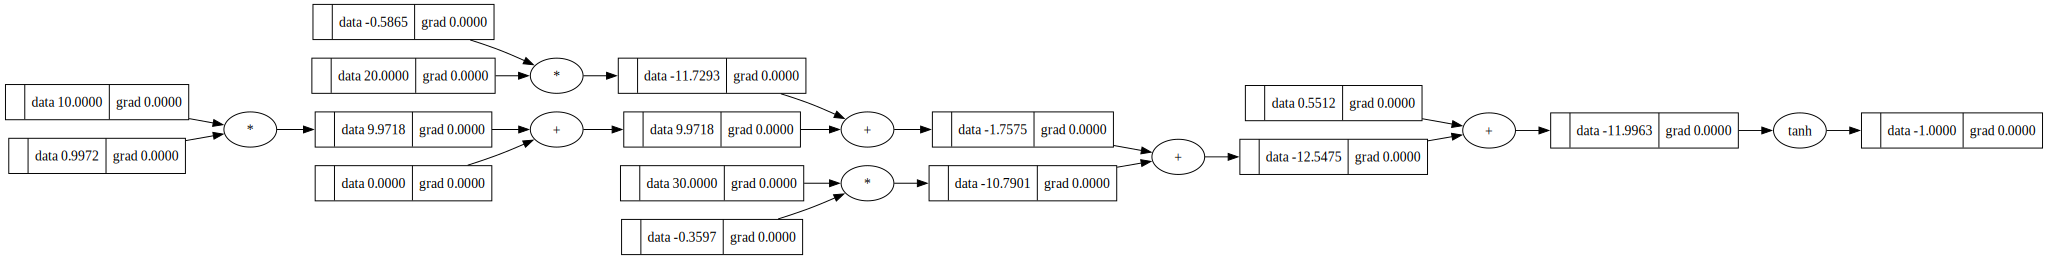

In [2802]:
draw_dot(o)

In [2803]:
n = Layer(2,3)
l = n([10,20])
m = Layer(3,1)
o = m(l)

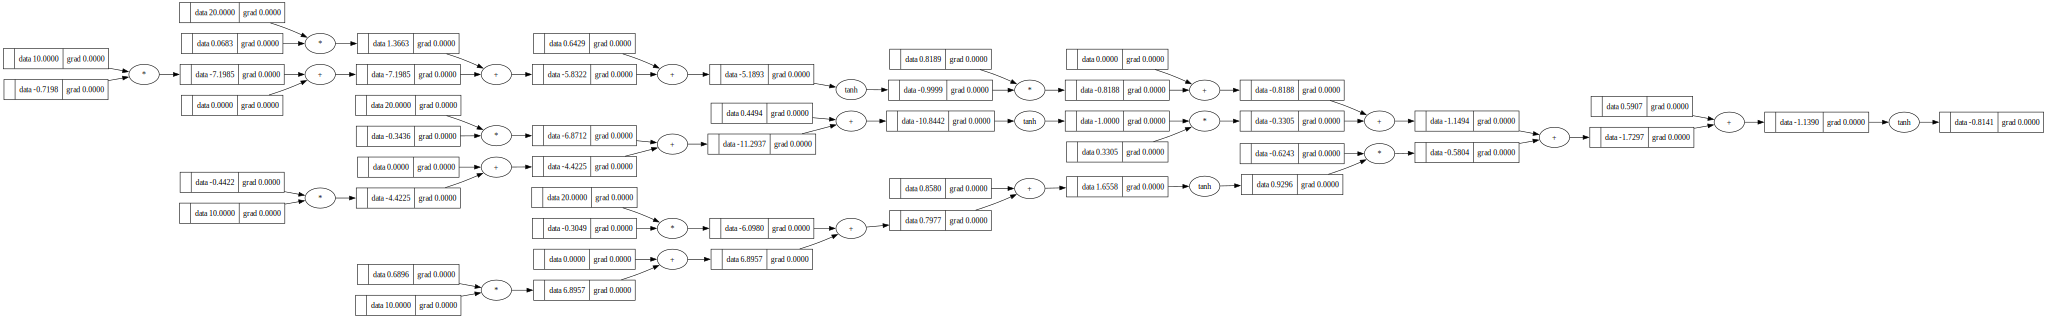

In [2804]:
draw_dot(o)

In [2805]:
m = MLP(3,[4,4,1])
x = [11,22,33]
o = m(x)
o

Value(data=0.22163239991218242)

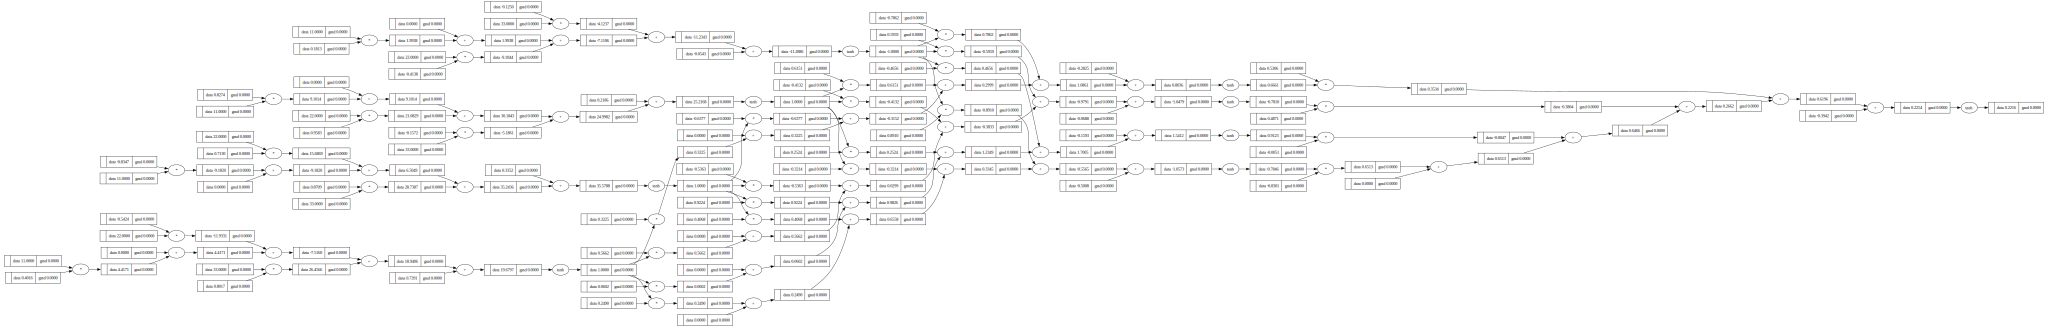

In [2806]:
draw_dot(o)

In [2807]:
xs = [
     [2.0,3.0,-1.0],
     [3.0,-1.0,0.5],
     [0.5,1.0,1.0],
     [1.0,1.0,-1.0]
]
ys = [1.0,-1.0,-1.0,1.0] #目标求解

In [2808]:
ypred = [m(x) for x in xs]
ypred

[Value(data=0.263658495823489),
 Value(data=0.5251981079799628),
 Value(data=-0.07519545565700878),
 Value(data=0.4401498199385912)]

In [2809]:
loss = sum((yout-ygt)**2 for ygt,yout in zip(ys,ypred))
loss

Value(data=4.037123748710825)

In [2810]:
# draw_dot(loss)

In [2811]:
# caculate parameters
m.parameters()
# parameters
print(m.layers[0].neurons[0].w[0].data)
print(m.layers[0].neurons[0].w[0].grad)
print(sum([p for p in m.parameters()]))
len(m.parameters())
print(m.parameters())

0.4015501719938237
0
Value(data=4.4174876866997534)
[Value(data=0.7390523772502566), Value(data=0.4015501719938237), Value(data=-0.5424131465777047), Value(data=0.8017165469680683), Value(data=0.3351987546406885), Value(data=-0.8347315457096889), Value(data=0.7130430617961849), Value(data=0.8708696881146756), Value(data=0.21861159230455462), Value(data=0.8274037868941706), Value(data=0.9583120897018136), Value(data=-0.15715365050054642), Value(data=-0.05432106278065629), Value(data=0.1812582203193327), Value(data=-0.4138381271140541), Value(data=-0.12496059914956326), Value(data=-0.5007648147244741), Value(data=0.2490499099687946), Value(data=0.4067738212073577), Value(data=-0.32136408423686236), Value(data=0.8909802080514706), Value(data=-0.15934863208411665), Value(data=0.06019815588827249), Value(data=0.9223767172233881), Value(data=0.2523589870011844), Value(data=-0.46559603119976867), Value(data=-0.06875198163305596), Value(data=0.5662188982716327), Value(data=-0.5363365350515701)

In [2812]:
# 记住每次反向传播之前需要将全部参数的梯度归零，因为在Value中梯度使用了累加操作符解决同一个变量的多次引用的梯度覆写问题
for p in m.parameters():
    p.grad=0

In [2813]:
loss.backward()

In [2814]:
# caculate parameters
m.parameters()
# parameters
print(m.layers[0].neurons[0].w[0].data)
print(m.layers[0].neurons[0].w[0].grad)
print(sum([p for p in m.parameters()]))
len(m.parameters())
print(m.parameters())

0.4015501719938237
-0.4107418339783268
Value(data=4.4174876866997534)
[Value(data=0.7390523772502566), Value(data=0.4015501719938237), Value(data=-0.5424131465777047), Value(data=0.8017165469680683), Value(data=0.3351987546406885), Value(data=-0.8347315457096889), Value(data=0.7130430617961849), Value(data=0.8708696881146756), Value(data=0.21861159230455462), Value(data=0.8274037868941706), Value(data=0.9583120897018136), Value(data=-0.15715365050054642), Value(data=-0.05432106278065629), Value(data=0.1812582203193327), Value(data=-0.4138381271140541), Value(data=-0.12496059914956326), Value(data=-0.5007648147244741), Value(data=0.2490499099687946), Value(data=0.4067738212073577), Value(data=-0.32136408423686236), Value(data=0.8909802080514706), Value(data=-0.15934863208411665), Value(data=0.06019815588827249), Value(data=0.9223767172233881), Value(data=0.2523589870011844), Value(data=-0.46559603119976867), Value(data=-0.06875198163305596), Value(data=0.5662188982716327), Value(data=-0

In [2815]:
# 调整所有的参数，使其朝损失函数梯度下降的方向变化
learning_rate = 0.01
for p in m.parameters():
    print('-----')
    print(p.data,p.grad)
    p.data += -1*learning_rate*p.grad
    print(p.data,-1*learning_rate*p.grad)

-----
0.7390523772502566 -0.25305047325158836
0.7415828819827726 0.0025305047325158837
-----
0.4015501719938237 -0.4107418339783268
0.405657590333607 0.004107418339783268
-----
-0.5424131465777047 -0.47229115203158395
-0.5376902350573889 0.00472291152031584
-----
0.8017165469680683 0.45713723815862023
0.797145174586482 -0.0045713723815862025
-----
0.3351987546406885 0.5237648572075418
0.32996110606861306 -0.005237648572075418
-----
-0.8347315457096889 1.0351630300167614
-0.8450831760098565 -0.010351630300167614
-----
0.7130430617961849 1.557059393161882
0.6974724678645661 -0.01557059393161882
-----
0.8708696881146756 -1.048929531445348
0.8813589834291291 0.01048929531445348
-----
0.21861159230455462 0.23677820649670556
0.21624381023958758 -0.0023677820649670557
-----
0.8274037868941706 0.38643012252350867
0.8235394856689355 -0.0038643012252350868
-----
0.9583120897018136 0.020391764231521073
0.9581081720594984 -0.00020391764231521072
-----
-0.15715365050054642 0.19165844403530483
-0.15

In [2816]:
print(m.layers[0].neurons[0].w[0].data)

0.405657590333607


In [2817]:
ypred = [m(x) for x in xs]
loss = sum((yout-ygt)**2 for ygt,yout in zip(ys,ypred))
loss

Value(data=3.5030803950679905)

In [2825]:
# 整个神经网络的训练过程可以概括为以下几个步骤
# 1.正向传播，得到初始的预测值
# 2.通过初始预测值和实际目标值通过损失函数计算loss
# 3.将所有参数的梯度初始化为0
# 4.根据loss function进行反向传播，计算所有节点对应目标值的梯度，目的是将loss值控制到接近0从而使得预测值与目标值符合
# 5.将各个节点的权重参数w向梯度反方向移动基于该梯度的微小值来缓慢的降低loss的值（如果该点的梯度为正值，那么说明该节点
#   值的增加将会导致loss function求出的值增大，为了达到减小loss值的目的，需要缩小该点的求值，data的固有值是无法改变的，
#   那么就修改其权重wi,将 w_i = w_i+-1*learning_rate*grad_i 即可缩小该点的整体值，直观上就是将该点向梯度的反方向即负值移动。）
# 6.将修正w_i后的神经网络再次重复 步骤1 的正向传播，然后开始循环直至loss下降到指定的接近0的可接受范围或者是训练循环达到最大迭代次数

for i in range(100):
    ypred = [m(x) for x in xs]
    loss = sum((yout-ygt)**2 for ygt,yout in zip(ys,ypred))
    for p in m.parameters():
        p.grad=0.0
    loss.backward()
    learning_rate = 0.05
    for p in m.parameters():
        p.data += -1*learning_rate*p.grad
    print(i,loss.data)

0 0.0013782192580199463
1 0.0013749768933246143
2 0.0013717494546407615
3 0.0013685368400070956
4 0.0013653389483843305
5 0.0013621556796447956
6 0.0013589869345622487
7 0.001355832614801781
8 0.001352692622909847
9 0.0013495668623044544
10 0.0013464552372654595
11 0.001343357652925066
12 0.0013402740152582784
13 0.00133720423107374
14 0.001334148208004384
15 0.00133110585449853
16 0.0013280770798107864
17 0.0013250617939933444
18 0.0013220599078871819
19 0.0013190713331135222
20 0.0013160959820652733
21 0.0013131337678987459
22 0.0013101846045253055
23 0.0013072484066032238
24 0.0013043250895296728
25 0.0013014145694327036
26 0.001298516763163445
27 0.0012956315882883347
28 0.0012927589630814498
29 0.0012898988065170014
30 0.0012870510382618381
31 0.0012842155786680857
32 0.0012813923487659255
33 0.001278581270256323
34 0.001275782265504074
35 0.001272995257530666
36 0.0012702201700075068
37 0.0012674569272489824
38 0.0012647054542057998
39 0.0012619656764583267
40 0.00125923752020999

In [2819]:
ypred

[Value(data=0.94717775941881),
 Value(data=-0.9338050523065301),
 Value(data=-0.9550499368682169),
 Value(data=0.9201801680827085)]

In [2823]:
xx = [3,2,1]
m(x)

Value(data=-0.9954665376504714)